# Fault plots split by regino

Final fault plot, split by region, for the report. This will be the final plot in Section 3.

MW, 18/7/25

In [171]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd
import geopandas as gpd
import shapely
import rasterio

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [172]:
# Set up a dictionary for storms
storms = {
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
    # "Storm Henk": ["2024-01-02", "2024-01-02"],
    # "Storm Isha": ["2024-01-19", "2024-01-22"],
#     "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
}

# Set up different colours for the storms
storm_colours = {
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
    # "Storm Henk": "cyan",
    # "Storm Isha": "magenta",
    # "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
}

In [173]:
region_dict = {
    17: 'North Scotland (SSEN)',
    18: 'South and Central Scotland (SPEN)',
    16: 'North West England (ENWL)',
    15: 'North East England (NPG)',
    23: 'Yorkshire (NPG)',
    13: 'North Wales, Merseyside and Cheshire (SPEN)',
    20: 'South East England (SSEN)',
    # Add more as more DNO data is available to be plotted
}

#Set up colours when plotting all regions on same plot
region_colors = {
    15: 'blue',
    16: 'orange',
    17: 'green',
    20: 'red',
    23: 'pink'
}


In [76]:
# Load all fault data (already combined into one file and filtered to remove non-meteorological faults)
all_faults = pd.read_csv('../faults/fault_data/combined_weather_fault_data_normalised.csv', usecols=lambda x: not x.startswith("Unnamed"))
all_faults['Population-weight customers affected'] = all_faults['Population-weight customers affected'].astype(str).str.replace(',', '').astype(float)

#Drop NANs and combine date and time
all_faults = all_faults.dropna(subset=['Start date'])
all_faults['Start date'] = pd.to_datetime(
    all_faults['Start date']
)

#Process faults
all_faults = all_faults.drop(['Code', 'DNO', 'Cause', 'Category', 'Start time', 'Duration (minutes)', 'CML', 'Customers affected', 'Population-weight CML', 'Voltage', 'Location', 'Latitude', 'Longitude', 'Normalised population-weighted CML', 'Normalised population-weighted customers affected'], axis=1)
all_faults = all_faults.groupby(['Region', 'Start date'], as_index=False).sum()

all_faults['Normalised population-weighted customers affected'] = all_faults.groupby('Region')['Population-weight customers affected'].transform(lambda x: x / x.max())

all_faults =  all_faults.set_index('Start date')

In [77]:
all_faults.head()

,Region,Population-weight customers affected,Normalised population-weighted customers affected
Start date,,,
2024-04-03,15.0,25.445293,0.000009
2024-04-06,15.0,42010.178116,0.015575
2024-04-07,15.0,15292.620869,0.005670
2024-04-10,15.0,127.226463,0.000047
2024-04-19,15.0,20483.460559,0.007594


In [146]:
# ------------------------------
# SPEN Faults - South Scotland and North Wales
# ------------------------------

# Load in the SPEN data as csv
spen_faults = pd.read_csv("../faults/fault_data/SPEN/all-lv-faults-spd-spm.csv")

# Subset to "Reporting Year" == 2024 (April 2023 to March 2024)
spen_faults_2024 = spen_faults[spen_faults["Reporting Year"].isin([2024])]

# Split into South Scotland and North Wales
# SPM - England and North Wales
# SPD - South Scotland
spen_faults_N_Wales_2024 = spen_faults_2024.copy()[spen_faults_2024["Licence"] == "SPM"]
spen_faults_S_Scotland_2024 = spen_faults_2024.copy()[spen_faults_2024["Licence"] == "SPD"]

#Weight by population (cosine-weighted)
spen_faults_N_Wales_2024['Population-weighted customers affected'] = spen_faults_N_Wales_2024['Customers Interrupted'] / 0.0435
spen_faults_S_Scotland_2024['Population-weighted customers affected'] = spen_faults_S_Scotland_2024['Customers Interrupted'] / 0.05

# ------------------------------
# NOTE: The SPEN faults data does not have a Cause Code, so we cannot filter by Cause Code like we did for SSEN.
# ------------------------------

In [147]:
spen_faults_N_Wales_2024 = spen_faults_N_Wales_2024.dropna(subset=['Date/Time of Incidents'])
spen_faults_N_Wales_2024['Date/Time of Incidents'] = pd.to_datetime(
    spen_faults_N_Wales_2024['Date/Time of Incidents']
)

spen_faults_S_Scotland_2024 = spen_faults_S_Scotland_2024.dropna(subset=['Date/Time of Incidents'])
spen_faults_S_Scotland_2024['Date/Time of Incidents'] = pd.to_datetime(
    spen_faults_S_Scotland_2024['Date/Time of Incidents']
)

/var/folders/k9/wbf996vd0bqfx_k_3z8ytlq40000gq/T/ipykernel_4642/782958940.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  spen_faults_N_Wales_2024['Date/Time of Incidents'] = pd.to_datetime(
/var/folders/k9/wbf996vd0bqfx_k_3z8ytlq40000gq/T/ipykernel_4642/782958940.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  spen_faults_S_Scotland_2024['Date/Time of Incidents'] = pd.to_datetime(


In [148]:
spen_faults_N_Wales_2024.columns.unique()

Index(['Master Job Ref', 'Job Ref', 'Split Incident', 'Reporting Year',
       'Date/Time of Incidents', 'IIP Reporting Scheme Code', 'Licence',
       'District', 'Circuit Code', 'Circuit Code Description',
       'LV Transformers ID', 'LV Substation Name', 'Customers Interrupted',
       'Population-weighted customers affected'],
      dtype='object')

In [149]:
spen_faults_N_Wales_2024.head()

,Master Job Ref,Job Ref,Split Incident,Reporting Year,Date/Time of Incidents,IIP Reporting Scheme Code,Licence,District,Circuit Code,Circuit Code Description,LV Transformers ID,LV Substation Name,Customers Interrupted,Population-weighted customers affected
39239,INCD-2206256-i,INCD-2206256-i,N,2024.0,2024-08-19 12:39:59+01:00,SERVICES,SPM,Merseyside,10303,CAMBRIDGE ROAD; Rawlinson Road,151768T1,PITT STREET 01/3516/006 GM S/S,1.0,22.988506
39242,INCD-2206412-i,INCD-2206412-i,N,2024.0,2024-08-19 19:22:59+01:00,LV,SPM,Wirral,45802,WERVIN; L0221 Plenstall Close Hoole Vill,100676T1,BANK FARM 04/4469/013 PM S/S,1.0,22.988506
39243,INCD-2203880-i,INCD-2203880-i,N,2024.0,2024-08-19 20:00:00+01:00,LV,SPM,Mid Cheshire,65204,FISONS; Bromley Drive,139515T1,PORTREE DRIVE 06/7666/012,3.0,68.965517
39245,INCD-562930-r,INCD-562930-r,N,2024.0,2024-08-19 20:32:59+01:00,LV,SPM,North Wales,81201,LLANGAFFO; Newborough,143231T1,TAN ROFFT 08/4265/004 PM S/S,1.0,22.988506
39248,INCD-562960-r,INCD-562960-r,N,2024.0,2024-08-20 08:34:59+01:00,LV,SPM,North Wales,82503,EDERN; Tudweiliog Botwnnog,105690T1,GROESFFORDD 08/2739/001 PM S/S,5.0,114.942529


In [150]:
spen_faults_N_Wales_2024 = spen_faults_N_Wales_2024.drop(['Master Job Ref', 'Job Ref', 'Split Incident', 'Reporting Year',
       'IIP Reporting Scheme Code', 'Licence',
       'District', 'Circuit Code', 'Circuit Code Description',
       'LV Transformers ID', 'LV Substation Name', 'Customers Interrupted'], axis=1).set_index('Date/Time of Incidents')
spen_faults_N_Wales_2024.index = pd.to_datetime(spen_faults_N_Wales_2024.index, utc=True)
spen_faults_N_Wales_2024.index.name = 'Start date'
spen_faults_N_Wales_2024 = spen_faults_N_Wales_2024.resample('D').sum()
spen_faults_N_Wales_2024['Normalised population-weighted customers affected'] = spen_faults_N_Wales_2024['Population-weighted customers affected'].transform(lambda x: x / x.max())
spen_faults_N_Wales_2024.head()

,Population-weighted customers affected,Normalised population-weighted customers affected
Start date,,
2024-04-01 00:00:00+00:00,3540.229885,0.073090
2024-04-02 00:00:00+00:00,3402.298851,0.070242
2024-04-03 00:00:00+00:00,2137.931034,0.044139
2024-04-04 00:00:00+00:00,5402.298851,0.111533
2024-04-05 00:00:00+00:00,2689.655172,0.055529


In [151]:
spen_faults_S_Scotland_2024 = spen_faults_S_Scotland_2024.drop(['Master Job Ref', 'Job Ref', 'Split Incident', 'Reporting Year',
       'IIP Reporting Scheme Code', 'Licence',
       'District', 'Circuit Code', 'Circuit Code Description',
       'LV Transformers ID', 'LV Substation Name', 'Customers Interrupted'], axis=1).set_index('Date/Time of Incidents')
spen_faults_S_Scotland_2024.index = pd.to_datetime(spen_faults_S_Scotland_2024.index, utc=True)
spen_faults_S_Scotland_2024.index.name = 'Start date'
spen_faults_S_Scotland_2024 = spen_faults_S_Scotland_2024.resample('D').sum()
spen_faults_S_Scotland_2024['Normalised population-weighted customers affected'] = spen_faults_S_Scotland_2024['Population-weighted customers affected'].transform(lambda x: x / x.max())
spen_faults_S_Scotland_2024.head()

,Population-weighted customers affected,Normalised population-weighted customers affected
Start date,,
2024-04-01 00:00:00+00:00,3120.0,0.156313
2024-04-02 00:00:00+00:00,11620.0,0.582164
2024-04-03 00:00:00+00:00,7720.0,0.386774
2024-04-04 00:00:00+00:00,12540.0,0.628257
2024-04-05 00:00:00+00:00,19140.0,0.958918


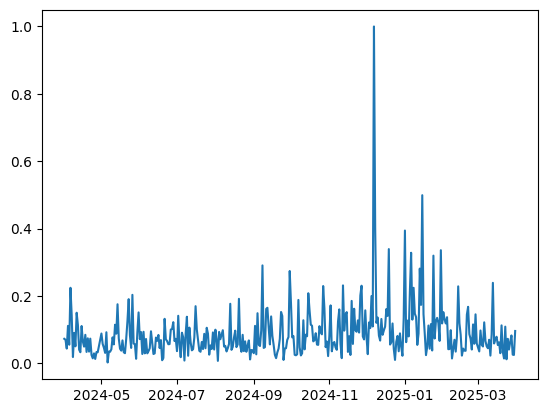

In [156]:
#Check SPEN faults in North Wales look sensible

plt.plot(spen_faults_N_Wales_2024.index,spen_faults_N_Wales_2024['Normalised population-weighted customers affected'])

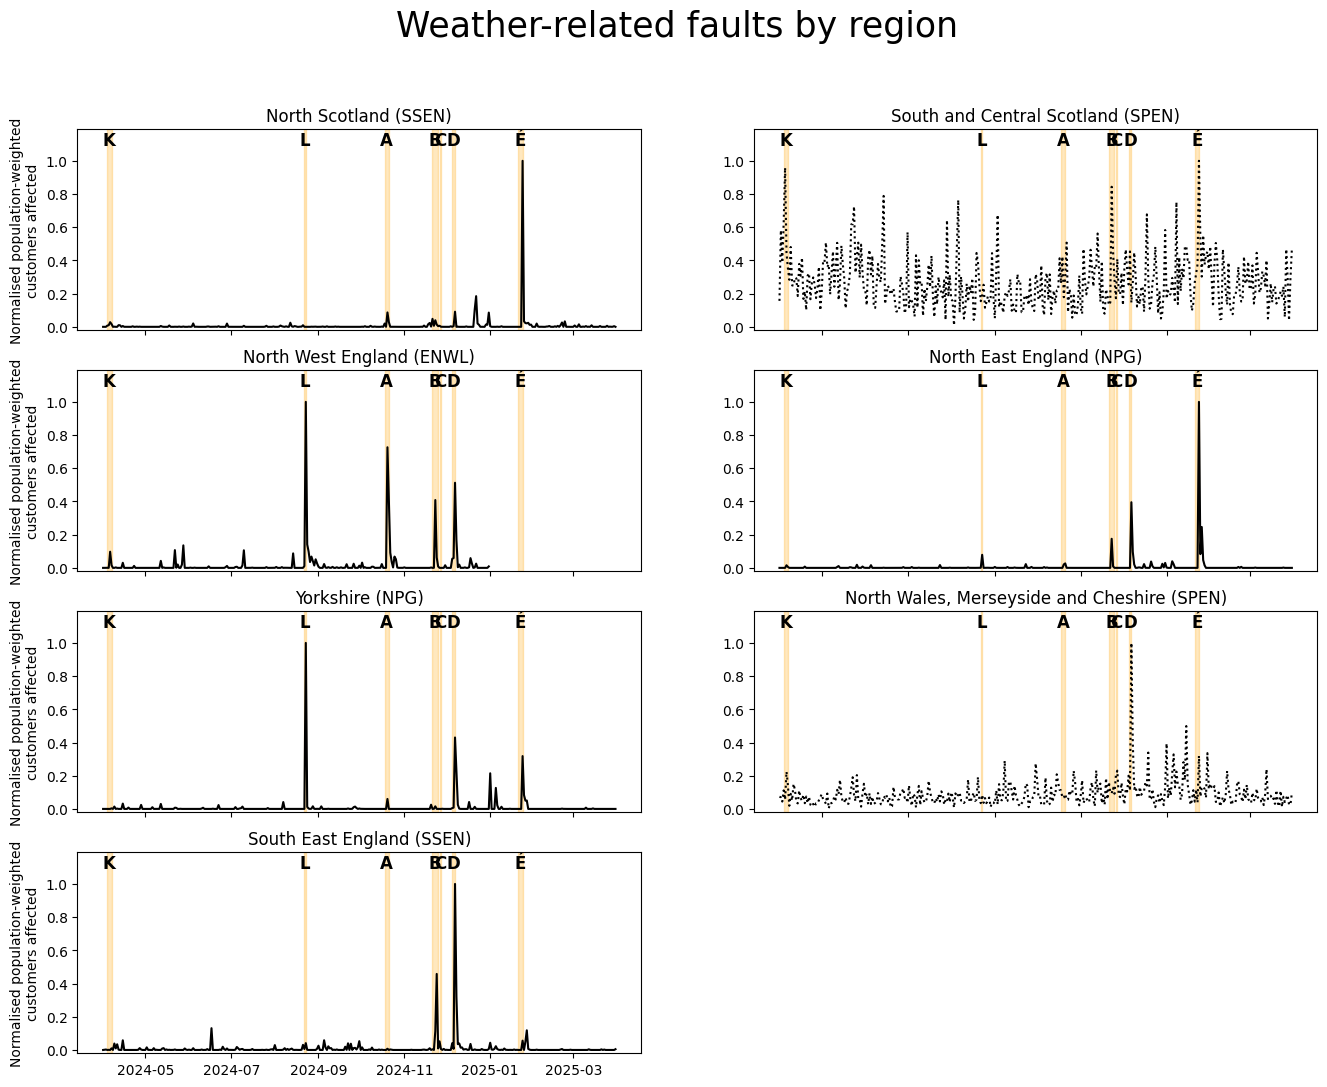

In [170]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)
axs = axs.flatten()


for i, (region_number, region_name) in enumerate(region_dict.items()):
    if region_number == 13: #North Wales SPEN data
        subset = spen_faults_N_Wales_2024
        ls = ':'
    elif region_number == 18: #South Scotland SPEN data
        subset = spen_faults_S_Scotland_2024
        ls = ':'
    elif region_number == 16: #Crop to end on 31 December for ENWL as that is when data runs out
        subset = all_faults[(all_faults['Region'] == region_number)]
        subset = subset.reindex(pd.date_range('2024-04-01','2024-12-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
        ls = '-'
    else: #Subset rest to full period
        subset = all_faults[(all_faults['Region'] == region_number)]
        subset = subset.reindex(pd.date_range('2024-04-01','2025-03-31'), fill_value=0) #Reindex for smooth time series, with 0 values for dates with no CML
        ls = '-'
    
    axs[i].plot(
        subset.index,
        subset['Normalised population-weighted customers affected'],
        color='k',
        ls=ls
    )
    axs[i].set_title(region_name)
    axs[i].set_ylim(-0.02,1.19) #Same y limits for all

    # Loop through the storms and plot the time periods
    for storm, dates in storms.items():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
        end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive   
        # Midpoint of the storm period
        midpoint = start_date + (end_date - start_date) / 2
        # First letter of the storm name (skip "Storm " prefix)
        first_letter = storm.split()[1][0]  # e.g. "Ashley" -> "A"
        # Place the letter just at the top of the plot
        axs[i].text(midpoint, axs[i].set_ylim()[1]*0.9, first_letter, color='k',
                fontsize=12, fontweight='bold', ha='center', va='bottom')
        axs[i].axvspan(start_date, end_date, color='orange', alpha=0.25, label=storm, zorder=-99) #color=storm_colours[storm],

    if i in [0, 2, 4, 6]:
        axs[i].set_ylabel("Normalised population-weighted\ncustomers affected")
    else:
        axs[i].set_xlabel("")

axs[-1].axis('off')
plt.suptitle('Weather-related faults by region', fontsize=25)
plt.savefig('../plots/faults_by_region.png')
plt.show()


## Testing signal detection/filtering methods for SPEN data to see if they would improve results for SPEN data

Decided not to use this in the end -- will overcomplicate things and not add loads of value

In [164]:
from scipy.signal import savgol_filter, find_peaks
south_scotland_values = spen_faults_S_Scotland_2024['Normalised population-weighted customers affected']
smoothed_south_scotland_values = savgol_filter(south_scotland_values, window_length=7, polyorder=2)
residual_south_scotland_values = south_scotland_values - smoothed_south_scotland_values
peaks_south_scotland, _ = find_peaks(residual_south_scotland_values, prominence=100)
adjusted_south_scotland_values = south_scotland_values - south_scotland_values.mean()
peaks_south_scotland

array([], dtype=int64)

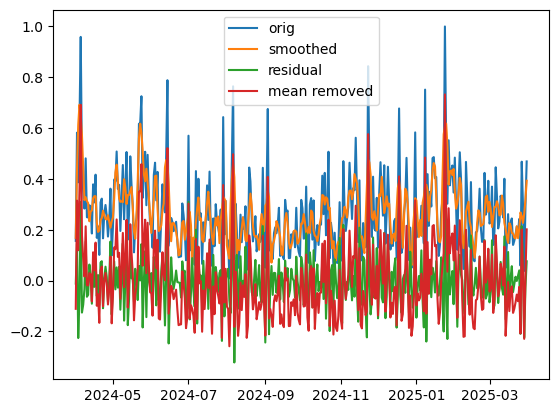

In [165]:
plt.plot(south_scotland_values.index,south_scotland_values, label='orig')
plt.plot(south_scotland_values.index,smoothed_south_scotland_values, label='smoothed')
plt.plot(south_scotland_values.index,residual_south_scotland_values, label='residual')
plt.plot(south_scotland_values.index,adjusted_south_scotland_values, label='mean removed')

plt.legend()